In [1]:
# Author: Antti Kiviaho
# Date: 10.5.2023

import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial')
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import anndata as ad

from scripts.utils import load_from_pickle
from scipy.stats import chisquare
from datetime import datetime
import igraph as ig
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


## Function definitions

In [2]:

def score_modules(ctype, genes_dict):
    dat = sc.read_h5ad('nmf_annotation/'+ ctype + '.h5ad')
    dat.X = dat.layers['counts'].copy()

    for k in genes_dict.keys():
        lst = genes_dict[k]

        # Score the gene expression data.
        sc.tl.score_genes(dat, gene_list=lst, score_name=k, ctrl_size=len(lst), random_state=3523569)

    # Find the column with the highest score and add a new column for the corresponding module.
    score_cols = list(genes_dict.keys())

    max_col = dat.obs[score_cols].idxmax(axis=1)
    dat.obs['max_scoring'] = max_col

    #obs_data = dat.obs.copy()

    return(dat)


def calculate_phenotype_distributions(df,annot_col='annotation'):

    # Phenotype proportions in the celltype as a whole
    bground_proportions = df['phenotype'].value_counts()/len(df)
    order = bground_proportions.index

    for module in df[annot_col].unique():
        # The number of cells scoring highest on this module
        subset = df[df[annot_col] == module]
        # Expected proportions based on the celltype proportions
        expected = bground_proportions*len(subset)

        observed = subset['phenotype'].value_counts()[order]

        contig_table = pd.DataFrame({'expected':expected.astype(int),
        'observed':observed,
        'diff':observed-expected.astype(int)})

        pval = chisquare(observed,expected).pvalue

        print(module+': top scoring in ' + str(len(subset))+' cells')
        print(contig_table)
        print('chi2 test p-value: ' + str(pval))
        print('')

    
def plot_score_violins(scores_df,group_col='max_scoring'):
    # Take all columns with module in their name
    module_columns = [col for col in scores_df.columns if 'module' in col]
    module_columns.append(group_col)

    if len(module_columns) > 0:
        violin_df = scores_df[module_columns]

        rows = len(module_columns)//2
        fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))

        for i in range(len(module_columns)-1): # Don't plot the last column
            row = i // 2
            col = i % 2
            
            sns.violinplot(data=violin_df, x=group_col, y=module_columns[i], ax=axs[row][col])
            axs[row][col].tick_params(axis='x', rotation=30)

            # Get the 1st quantile of highest scoring module
            val_80 = violin_df.loc[violin_df[group_col] == module_columns[i],module_columns[i]].quantile(q=0.25)

            # Add horizontal line
            axs[row][col].axhline(y=val_80, color='black', linestyle='--')

        
        plt.show()
    else:
        print("No columns found with 'module' in their names.")


def save_dict_to_excel(dict_with_modules,ctype):
    # Saves the factors to a dataframe and onto an excel sheet
    max_length = max(len(lst) for lst in dict_with_modules.values())
    for key in dict_with_modules:
        dict_with_modules[key].extend([np.nan]*(max_length - len(dict_with_modules[key])))

    df_with_modules = pd.DataFrame.from_dict(dict_with_modules)
    df_with_modules.to_excel(ctype+'_modules_'+datetime.today().strftime('%Y%m%d')+'.xlsx')
    

def create_modules_from_adjacency_matrix(fname,min_modules_per_connection=5,
                                         min_connections_per_gene=5,min_genes_in_module=10,
                                         plot_clustermap=True):
    
    import random
    random.seed(235693923)
    '''
    This is a function that takes an adjacency matrix of gene connections as 
    input and generates clusters of genes using the Leiden algorithm implemented 
    in the python module igraph. The clusters are then filtered and returned in the
    form of a dictionary with keys as module indexes and values as lists of gene
    names. The function includes a number of default arguments, such as minimum
    number of modules per connection (5), minimum number of connections per gene (5),
    minimum number of genes in a module (10), and a boolean flag to indicate whether
    to plot a clustermap using seaborn (True). The function works by filtering the 
    adjacency matrix to remove weak connections, then using the igraph module to group
    the genes in clusters. The clusters are filtered for minimum size and sorted by size.
    The resulting gene modules are returned as a dictionary, and a seaborn clustermap is
    plotted if desired.
    '''
    adj_df = pd.read_csv('nmf_annotation/'+fname,index_col=0)

    # Filter connections occurring in fewer than 5 modules
    adj_df[adj_df<min_modules_per_connection] = 0

    # Filter genes with less than 5 connections
    adj_df = adj_df[adj_df.astype(bool).sum(axis=1) >= min_connections_per_gene]

    # Filter the columns as well
    adj_df = adj_df[adj_df.index] 

    # create graph object
    g = ig.Graph.Adjacency(np.matrix(adj_df),mode='undirected')

    # find clusters
    clusters = g.community_leiden()

    # Extract cluster labels and link them to genes (index)
    labels = pd.Series(clusters.membership)
    labels.index = adj_df.index.copy()

    # Filter the modules by minimum number of genes present and sort them by the number of genes 
    labels_to_keep = list(labels.value_counts()[pd.Series(labels).value_counts() >= min_genes_in_module].index)

    # Save the genes of each module (cluster) to a dictionary
    modules = {}
    for idx,l in enumerate(labels_to_keep):
        modules['module'+str(idx)] = list(adj_df[labels == l].index)

    adj_df = adj_df[[value for key in modules for value in modules[key]]]
    adj_df = adj_df.loc[[value for key in modules for value in modules[key]]]

    if plot_clustermap:
        sns.clustermap(adj_df, cmap='magma', figsize=(6,6),row_cluster=False,col_cluster=False,
                       vmax=np.quantile(np.matrix(adj_df),0.99))


    # Return the dictionary
    return(modules, adj_df)

def score_modules_ttest_1samp(dat, genes_dict,p_val_thr=0.05): 

    sc.pp.scale(dat)

    mods = list(genes_dict.keys())

    # Loop over the gene modules
    for k in genes_dict.keys():

        lst = genes_dict[k]

        # Subset the data to just the genes in question
        subs_X = dat.X[:, np.where(dat.var_names.isin(lst))[0]]

        # One-sample t-test to see whether the gene set is active
        t, p_vals = ttest_1samp(subs_X, axis=1, popmean=0, alternative='greater')

        # Save the p-values into the original dat anndata observations.
        dat.obs[k] = p_vals

    # Perform p-value correction
    dat_obs = dat.obs[mods]

    # Perform Benjamini-Hochberg correction on each column of the DataFrame
    for column in dat_obs.columns:
        pvals = dat_obs[column].values
        reject, corr_pvals, _, _ = multipletests(pvals, method='fdr_bh')
        dat_obs[column] = corr_pvals


    # Update the original DataFrame with the corrected p-values
    dat.obs[mods] = dat_obs

    # Take each column with an adjusted p_value < 0.05 and concatenate the modules into a string and save it row-wise (annotation)
    dat.obs['annotation'] = (dat.obs[mods] < p_val_thr).astype(int).multiply(dat.obs[mods].columns.str.replace('module','_')).sum(axis=1)
    return(dat)



## Annotating immune cells

Ran celltypist in 'single-cell-immune-celltypist' notebook (24.8.2023)

In [3]:
immune_cell_annotations = pd.read_csv('./celltypist_dir/celltypist_predicted_labels_20230824.csv',index_col=0)
immune_cell_annotations['predicted_labels']

D17_GATCTAGTCCCTTGTG-1                   T cells
D17_GTAGTCACATGAAGTA-1               Macrophages
D17_ATAGACCTCTGTCCGT-2               Macrophages
D17_CGATCGGCAGTTTACG-2               Macrophages
D27_AAGGTTCCACTATCTT-3                   T cells
                                        ...     
SCG-PCA22-T-HG_CGTGTCTAGAGCTTCT-1        B cells
SCG-PCA18-T-LG_CGTGAGCTCCGCATCT-1        T cells
SCG-PCA9-T-LG_GCTTGAATCATGCTCC-1         T cells
SCG-PCA21-N-LG_ACATCAGCACAGGCCT-1        T cells
SCG-PCA20-N-LG_CGGTTAAGTACTCGCG-1        T cells
Name: predicted_labels, Length: 64567, dtype: object

In [23]:
# Create a dataframe for final annotations of all cells
final_annotations = pd.DataFrame()
final_annotations = pd.concat([final_annotations,immune_cell_annotations['predicted_labels']],axis=0)

## Revising the NMF strategy

The full list of modules obtained for individual tumors was filtered to retain only those with at least 5% overlap (by Jaccard index) with at least two other modules. An adjacency matrix was then constructed connecting genes according to the number of individual tumor modules in which they co-occur. Gene–gene connections were filtered out if they occurred in fewer than two individual tumor modules, and genes with fewer than three connections were removed. The graph was clustered using infomap clustering implemented in the igraph package v.1.2.11 (ref. 93). Finally, modules with potential biological relevance were retained by filtering out those with fewer than five genes or without significant overlap with gene ontology terms. The final graph (Extended Data Fig. 3f) was visualized with the Fruchterman–Reingold layout.

- Methods from Barkley et al. Nat. Genetics 2022

## Loading the NMF gene lists and scoring them

In [24]:
cells_pct_thr = 0.01
comparison = '_mod_5_jac0.1'
param1 = 5
param2 = 5

### Epithelial with a t-test based annotation of the data

In [25]:
ctype = 'Epithelial'

epithelial_modules, epithelial_adjacency_df = create_modules_from_adjacency_matrix(ctype+'_nmf_derived_gene_adjacencies'+comparison+'.csv',param1,param2)
save_dict_to_excel(epithelial_modules,ctype+comparison)

adata = sc.read_h5ad('nmf_annotation/'+ ctype + '.h5ad')

n_cells_per_type_thr = int(cells_pct_thr*len(adata))

adata = score_modules_ttest_1samp(adata,epithelial_modules)

In [7]:
# Filtering out cells that express ribosomal or heatshock protein (stress) genes
# Check the excel file for gene sets
remove_mods = ['8', '9']
for mod in remove_mods:
    epithelial_modules.pop('module'+mod, None)

adata = adata[~(adata.obs['annotation'].str.contains('|'.join(remove_mods)))]
adata.obs['annotation'] = ctype + adata.obs['annotation']

val_counts = adata.obs['annotation'].value_counts()
final_counts = val_counts[(val_counts.index !=ctype) &(val_counts>n_cells_per_type_thr)]

print('n cell types: ' + str(len(final_counts)))
print(str(final_counts.sum())+' out of '+str(adata.obs.shape[0])+' kept')
adata = adata[adata.obs['annotation'].isin(final_counts.index)]

final_counts


n cell types: 8
46273 out of 78061 kept


Epithelial_0      14578
Epithelial_2      10086
Epithelial_4       6164
Epithelial_2_4     5053
Epithelial_0_7     4310
Epithelial_3       2229
Epithelial_2_6     2111
Epithelial_0_3     1742
Name: annotation, dtype: int64

In [8]:
calculate_phenotype_distributions(adata.obs)

Epithelial_2: top scoring in 10086 cells
        expected  observed  diff
normal      5441      7066  1625
PCa         3937      1452 -2485
CRPC         707      1568   861
chi2 test p-value: 0.0

Epithelial_4: top scoring in 6164 cells
        expected  observed  diff
normal      3325      5148  1823
PCa         2406       997 -1409
CRPC         432        19  -413
chi2 test p-value: 0.0

Epithelial_2_4: top scoring in 5053 cells
        expected  observed  diff
normal      2725      3132   407
PCa         1972      1095  -877
CRPC         354       826   472
chi2 test p-value: 9.87755626006611e-235

Epithelial_0: top scoring in 14578 cells
        expected  observed  diff
normal      7864      7656  -208
PCa         5690      6778  1088
CRPC        1022       144  -878
chi2 test p-value: 4.889174339274473e-211

Epithelial_2_6: top scoring in 2111 cells
        expected  observed  diff
normal      1138       702  -436
PCa          824      1361   537
CRPC         148        48  -100
c

In [9]:
final_annotations = pd.concat([final_annotations,adata.obs['annotation']],axis=0)

### Fibroblast_muscle

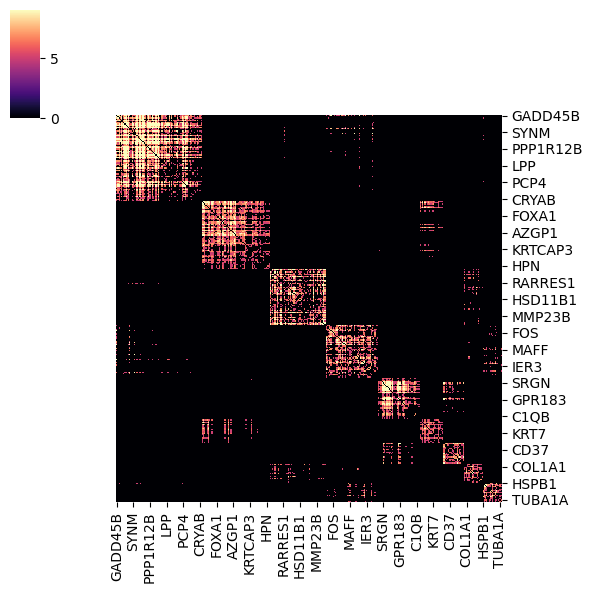

In [10]:
ctype = 'Fibroblast_muscle'
fibroblast_modules, adjacency_df = create_modules_from_adjacency_matrix(ctype+'_nmf_derived_gene_adjacencies'+comparison+'.csv',param1,param2)
save_dict_to_excel(fibroblast_modules,ctype+comparison)
adata = sc.read_h5ad('nmf_annotation/'+ ctype + '.h5ad')

n_cells_per_type_thr = int(cells_pct_thr*len(adata))

adata = score_modules_ttest_1samp(adata,fibroblast_modules)

In [11]:
# Filtering out cells that express ribosomal or heatshock protein (stress) genes
remove_mods = ['8']
for mod in remove_mods:
    fibroblast_modules.pop('module'+mod, None)

adata = adata[~(adata.obs['annotation'].str.contains('|'.join(remove_mods)))]
adata.obs['annotation'] = ctype + adata.obs['annotation']

val_counts = adata.obs['annotation'].value_counts()
final_counts = val_counts[(val_counts.index !=ctype) &(val_counts>n_cells_per_type_thr)] # Drop cells that didn't score for a module or are in a group with <  min_cells

print('n cell types: ' + str(len(final_counts)))
print(str(final_counts.sum())+' out of '+str(adata.obs.shape[0])+' kept')
adata = adata[adata.obs['annotation'].isin(final_counts.index)]

final_counts


n cell types: 7
10278 out of 18998 kept


Fibroblast_muscle_0      4553
Fibroblast_muscle_2      2363
Fibroblast_muscle_2_7     885
Fibroblast_muscle_3       702
Fibroblast_muscle_1_5     678
Fibroblast_muscle_0_3     661
Fibroblast_muscle_5       436
Name: annotation, dtype: int64

In [12]:
calculate_phenotype_distributions(adata.obs)

Fibroblast_muscle_2: top scoring in 2363 cells
        expected  observed  diff
normal      1568      1614    46
PCa          600       630    30
CRPC         193       119   -74
chi2 test p-value: 1.5941465620549167e-07

Fibroblast_muscle_5: top scoring in 436 cells
        expected  observed  diff
normal       289       427   138
PCa          110         0  -110
CRPC          35         9   -26
chi2 test p-value: 2.4683023674270826e-43

Fibroblast_muscle_0: top scoring in 4553 cells
        expected  observed  diff
normal      3022      3088    66
PCa         1157      1126   -31
CRPC         372       339   -33
chi2 test p-value: 0.0698192616567406

Fibroblast_muscle_0_3: top scoring in 661 cells
        expected  observed  diff
normal       438       170  -268
PCa          168       368   200
CRPC          54       123    69
chi2 test p-value: 3.696292434019145e-107

Fibroblast_muscle_1_5: top scoring in 678 cells
        expected  observed  diff
normal       450       666   216
PC

In [13]:
final_annotations = pd.concat([final_annotations,adata.obs['annotation']],axis=0)

### Endothelial

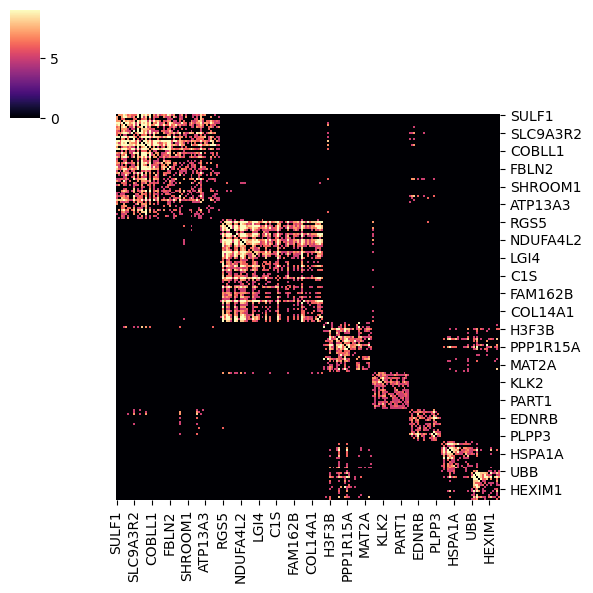

In [14]:
ctype = 'Endothelial'
endothelial_modules, adjacency_df = create_modules_from_adjacency_matrix(ctype+'_nmf_derived_gene_adjacencies'+comparison+'.csv',param1,param2)
save_dict_to_excel(endothelial_modules,ctype+comparison)
adata = sc.read_h5ad('nmf_annotation/'+ ctype + '.h5ad')

n_cells_per_type_thr = int(cells_pct_thr*len(adata))

adata = score_modules_ttest_1samp(adata,endothelial_modules)

In [15]:
# Filtering out cells that express ribosomal or heatshock protein (stress) genes
remove_mods = ['5']
for mod in remove_mods:
    endothelial_modules.pop('module'+mod, None)


adata = adata[~(adata.obs['annotation'].str.contains('|'.join(remove_mods)))]
adata.obs['annotation'] = ctype + adata.obs['annotation']

val_counts = adata.obs['annotation'].value_counts()
final_counts = val_counts[(val_counts.index !=ctype) &(val_counts>n_cells_per_type_thr)] # Drop cells that didn't score for a module or are in a group with <  min_cells

print('n cell types: ' + str(len(final_counts)))
print(str(final_counts.sum())+' out of '+str(adata.obs.shape[0])+' kept')
adata = adata[adata.obs['annotation'].isin(final_counts.index)]

final_counts


n cell types: 5
4223 out of 17163 kept


Endothelial_4      934
Endothelial_6      906
Endothelial_0      864
Endothelial_2_6    840
Endothelial_2      679
Name: annotation, dtype: int64

In [16]:
calculate_phenotype_distributions(adata.obs)

Endothelial_2: top scoring in 679 cells
        expected  observed  diff
PCa          426       285  -141
normal       220       331   111
CRPC          31        63    32
chi2 test p-value: 1.2960426473898516e-29

Endothelial_0: top scoring in 864 cells
        expected  observed  diff
PCa          542       602    60
normal       280       231   -49
CRPC          40        31    -9
chi2 test p-value: 0.0001682968424816341

Endothelial_4: top scoring in 934 cells
        expected  observed  diff
PCa          586       714   128
normal       303       190  -113
CRPC          43        30   -13
chi2 test p-value: 8.094017761419803e-17

Endothelial_2_6: top scoring in 840 cells
        expected  observed  diff
PCa          527       466   -61
normal       272       322    50
CRPC          39        52    13
chi2 test p-value: 4.084648526342752e-05

Endothelial_6: top scoring in 906 cells
        expected  observed  diff
PCa          569       587    18
normal       294       297     3
CR

In [17]:
final_annotations = pd.concat([final_annotations,adata.obs['annotation']],axis=0)

## Merging annotations with data

In [18]:
final_annotations = final_annotations.rename(columns={0:'final_annotation'})

In [19]:
adata = sc.read_h5ad('aggregate_sc_data_with_broad_annotation_20230823.h5ad')
adata.X = adata.layers['counts'].copy()
del adata.layers['counts']

In [20]:
merged_df = pd.merge(adata.obs, final_annotations, left_index=True, right_index=True, how='left')
#merged_df['final_annotation'] = merged_df['final_annotation'].fillna(merged_df['refined_celltypes'])

if (merged_df.index == adata.obs.index).all():
    adata.obs = merged_df.copy()
    print('Done')

# Removing the cells with nan as cell type reference
adata = adata[~adata.obs['final_annotation'].isna()]


Done


In [21]:
# Finished, annotated data
print(adata.obs['final_annotation'].value_counts())
print('')
print('The total number of different celltypes: ' + str(len(adata.obs['final_annotation'].unique())))

T cells                  48219
Epithelial_0             14578
Epithelial_2             10086
B cells                   7617
Epithelial_4              6164
Epithelial_2_4            5053
Fibroblast_muscle_0       4553
Epithelial_0_7            4310
Mast cells                3594
ILC                       2846
Fibroblast_muscle_2       2363
Macrophages               2291
Epithelial_3              2229
Epithelial_2_6            2111
Epithelial_0_3            1742
Endothelial_4              934
Endothelial_6              906
Fibroblast_muscle_2_7      885
Endothelial_0              864
Endothelial_2_6            840
Fibroblast_muscle_3        702
Endothelial_2              679
Fibroblast_muscle_1_5      678
Fibroblast_muscle_0_3      661
Fibroblast_muscle_5        436
Name: final_annotation, dtype: int64

The total number of different celltypes: 25


In [22]:
adata.write('./single_cell_reference_with_nmf_derived_annotations'+comparison+'_'+datetime.today().strftime('%Y%m%d')+'.h5ad')